In [1]:
# imports: 
import pandas as pd
import numpy as np 

#personal
import wrangle as wr
import explore as ex

# import 
import matplotlib.pyplot as plt


#statistical metrics:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model imports:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector

# Modeling:  

In [2]:
# aquire the data:
train, validate, test = wr.prep_zillow()
train.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
42282,2.5,4.0,1638.0,523394.0,1996.0,21.0,6.5
4905,1.0,3.0,1092.0,34323.0,1951.0,66.0,4.0
48029,2.0,3.0,1178.0,211910.0,1939.0,78.0,5.0
22673,2.0,2.0,1480.0,105574.0,1955.0,62.0,4.0
52519,3.0,3.0,1812.0,604601.0,1951.0,66.0,6.0


In [3]:
#scale the data:
to_scale = ['bathrooms','bedrooms','sqft','yearbuilt','house_age','bb_roomcnt']
train_scaled, validate_scaled, test_scaled = ex.scale_data(train, validate, test, to_scale)
train_scaled.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
42282,0.454545,0.6,0.292197,523394.0,0.847328,0.152672,0.611111
4905,0.181818,0.4,0.176421,34323.0,0.503817,0.496183,0.333333
48029,0.363636,0.4,0.194656,211910.0,0.412214,0.587786,0.444444
22673,0.363636,0.2,0.258694,105574.0,0.534351,0.465649,0.333333
52519,0.545455,0.4,0.329092,604601.0,0.503817,0.496183,0.555556


In [4]:
# split data into X_train and Y_train

X_train = train_scaled.drop(columns = 'tax_value')
y_train = train_scaled['tax_value']

X_validate = validate_scaled.drop(columns= 'tax_value')
y_validate = validate_scaled['tax_value']

X_test = test_scaled.drop(columns = 'tax_value')
y_train = train_scaled['tax_value']

In [5]:
X_train.shape

(29955, 6)

In [6]:
y_train.shape

(29955,)

# Feature Engineering: 
- What features are the best?
- What does RFE say is the best?

In [7]:
#top 3 features:

#make the object
kbest = SelectKBest(f_regression, k = 3)

#fit the ting:
kbest.fit(X_train, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x175e816c0>)

In [8]:
# statiscal f-value / featurer's scores:
kbest.scores_

array([ 8379.70463471,  2076.4468424 , 13045.32710785,  2589.30883293,
        2589.30883293,  5675.66277798])

In [9]:
# p value: 
kbest.pvalues_

array([0., 0., 0., 0., 0., 0.])

In [10]:
# get the names of the features its looking at: 
kbest.feature_names_in_

array(['bathrooms', 'bedrooms', 'sqft', 'yearbuilt', 'house_age',
       'bb_roomcnt'], dtype=object)

In [11]:
# make it into a dataframe
kbest_results = pd.DataFrame(
                dict(p=kbest.pvalues_, f=kbest.scores_),
                                        index = X_train.columns)
kbest_results

,p,f
bathrooms,0.0,8379.704635
bedrooms,0.0,2076.446842
sqft,0.0,13045.327108
yearbuilt,0.0,2589.308833
house_age,0.0,2589.308833
bb_roomcnt,0.0,5675.662778


What does RFE say?

In [12]:
lm = LinearRegression()

rfe = RFE(lm, n_features_to_select= 3)

rfe.fit(X_train, y_train)

ranks = rfe.ranking_
names = X_train.columns.tolist()

pd.DataFrame({'features': names, 'rank': ranks}).set_index('rank')

,features
rank,
1,bathrooms
3,bedrooms
4,sqft
1,yearbuilt
1,house_age
2,bb_roomcnt


In [13]:
# create the function: 
def select_kbest(x, y, k_value):
    '''
    This funciton will take in the predictors (x), the target(y), and the numebr of features to select and 
    returns the top k selectef features based on the SelectKbest class. 
    '''
    

    
    # make the thing: 
    kbest = SelectKBest(f_regression, k = k_value)
    
    #fit the thing
    kbest.fit(x, y)
    
    # return a dataframe with the names
    kbest_results = pd.DataFrame(
                dict(p=kbest.pvalues_, f=kbest.scores_),
                                        index = x.columns)
    
    # returns the dataframe with the top kbest features
    return kbest_results.head(k_value)

In [14]:
select_kbest(X_train, y_train, 3)

,p,f
bathrooms,0.0,8379.704635
bedrooms,0.0,2076.446842
sqft,0.0,13045.327108


In [15]:
# create a function: 
def rfe(x, y, k_value):
    '''
    This function will take in predicotrs(x), the target(y), and the number of features to select k_value
    It will return the top n feautres based on the RFE class.
    '''
    
    model = LinearRegression()
    
    rfe = RFE(model, n_features_to_select=k_value)
    
    rfe.fit(x, y)
    
    
    df = pd.DataFrame(
{
    'rfe_ranking':rfe.ranking_
}, index = X_train.columns)
    
    return df

In [16]:
rfe(X_train, y_train, 3)

,rfe_ranking
bathrooms,1
bedrooms,3
sqft,4
yearbuilt,1
house_age,1
bb_roomcnt,2


In [17]:
def rfe_2(X, y, k=3):
    rfe = RFE(LinearRegression(), n_features_to_select = k)
    rfe.fit(X, y)
    feature_mask = rfe.support_
    
    return X.iloc[:,feature_mask].columns.tolist()

In [18]:
rfe_2(X_train, y_train)

['bathrooms', 'yearbuilt', 'house_age']

Notes: 
- Select the K best features using a statistical test to compare each X with y and find which X's have the strongest relationship with y. For regression, we will use the correlation test (f-regression) to score the relationships.
- Recursive Feature Elimination will create a model with all the features, evaluate the performance metrics, find the weakest feature, remove it, then create a new model with the remaining features, evaluate the performance metrics, find the weakest feature, remove it, and so on, until it gets down to the number of features you have indicated you want when creating the RFE object. You will also need to indicate which Machine Learning algorithm you want to use.

# Modeling Part 1
- This will be the long method learned in class
- Complete each model by hand:
    - Ordinary Least Squares
    - LASSO + LARS
    - Polynomial Regression
    - Generalized Linear Model

##### Baseline: 

In [19]:
baseline = y_train.mean()
baseline

376952.94495075947

In [20]:
#evaluate function
def evaluate_reg(y, yhat):
    '''
    based on two series, y_act, y_pred, (y, yhat), we
    evaluate and return the root mean squared error
    as well as the explained variance for the data.
    
    returns: rmse (float), rmse (float)
    '''
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [21]:
#make an array to add to our database
baseline_array = np.repeat(baseline, y_train.shape[0])

In [22]:
baseline_rmse, baseline_r2 = evaluate_reg(y_train, baseline_array)

In [23]:
eval_df = pd.DataFrame([{
    'model': 'baseline',
    'rmse': baseline_rmse,
    'r2': baseline_r2
}])

In [24]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.0


One feature: yearbuilt

In [25]:
# build the model:

# with one feature: 
lr1 = LinearRegression()

# rfe has entered the chat:
rfe = RFE(lr1, n_features_to_select=1)

# fit
rfe.fit(X_train, y_train)

# transform
X_train_rfe_1 = rfe.transform(X_train)

X_val_rfe_1 = rfe.transform(X_validate)


In [26]:
rfe.get_feature_names_out()

array(['yearbuilt'], dtype=object)

In [27]:
# make predicitons with the model: 
lr1.fit(X_train_rfe_1, y_train)

# make predictions based on the model with one feature (selected by rfe)
y_pred_val = lr1.predict(X_val_rfe_1)

#evalute the model: 
evaluate_reg(y_train, lr1.predict(X_train_rfe_1))

#add it to the data frame:
rmse, r_2 = evaluate_reg(y_train, lr1.predict(X_train_rfe_1))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'ols_rfe_1',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [28]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.000000
1,ols_rfe_1,259363.113640,0.079567


In [29]:
# make a data frame to see how the model preforms in validate: 
val_rmse, val_r2 = evaluate_reg(y_validate, lr1.predict(X_val_rfe_1))
val_dict = {
    'model': 'ols_rfe_1',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [30]:
val_scores = [val_dict]

Two Features: Yearbuilt, houseage

In [31]:
# build the model:

# with one feature: 
lr2 = LinearRegression()

# rfe has entered the chat:
rfe = RFE(lr1, n_features_to_select=2)

# fit
rfe.fit(X_train, y_train)

# transform
X_train_rfe_2 = rfe.transform(X_train)

X_val_rfe_2 = rfe.transform(X_validate)

In [32]:
rfe.get_feature_names_out()

array(['yearbuilt', 'house_age'], dtype=object)

In [33]:
# make predicitons with the model: 
lr2.fit(X_train_rfe_2, y_train)

# make predictions based on the model with one feature (selected by rfe)
y_pred_val = lr2.predict(X_val_rfe_2)

#evalute the model: 
evaluate_reg(y_train, lr2.predict(X_train_rfe_2))

#add it to the data frame:
rmse, r_2 = evaluate_reg(y_train, lr2.predict(X_train_rfe_2))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'ols_rfe_2',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [34]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.000000
1,ols_rfe_1,259363.113640,0.079567
2,ols_rfe_2,259363.749996,0.079563


In [35]:
val_rmse, val_r2 = evaluate_reg(y_validate, lr2.predict(X_val_rfe_2))
val_dict = {
    'model': 'ols_rfe_2',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}
val_scores.append(val_dict)

Three features: bathrooms, yearbuilt, house_age

In [36]:
# build the model:

# with one feature: 
lr3 = LinearRegression()

# rfe has entered the chat:
rfe = RFE(lr3, n_features_to_select=3)

# fit
rfe.fit(X_train, y_train)

# transform
X_train_rfe_3 = rfe.transform(X_train)

X_val_rfe_3 = rfe.transform(X_validate)

In [37]:
rfe.get_feature_names_out()

array(['bathrooms', 'yearbuilt', 'house_age'], dtype=object)

In [38]:
# make predicitons with the model: 
lr3.fit(X_train_rfe_3, y_train)

# make predictions based on the model with one feature (selected by rfe)
y_pred_val = lr3.predict(X_val_rfe_3)

#evalute the model: 
evaluate_reg(y_train, lr3.predict(X_train_rfe_3))

#add it to the data frame:
rmse, r_2 = evaluate_reg(y_train, lr3.predict(X_train_rfe_3))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'ols_rfe_3',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [39]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.000000
1,ols_rfe_1,259363.113640,0.079567
2,ols_rfe_2,259363.749996,0.079563
3,ols_rfe_3,238825.445478,0.219565


In [40]:
val_rmse, val_r2 = evaluate_reg(y_validate, lr3.predict(X_val_rfe_3))
val_dict = {
    'model': 'ols_rfe_3',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}
val_scores.append(val_dict)

All Features:

In [41]:
lr4 = LinearRegression()

lr4.fit(X_train, y_train)

rmse, r_2 = evaluate_reg(y_train, lr4.predict(X_train))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'ols_all_feats',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [42]:
val_rmse, val_r2 = evaluate_reg(y_validate, lr4.predict(X_validate))
val_dict = {
    'model': 'ols_all_feats',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}
val_scores.append(val_dict)

In [43]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.000000
1,ols_rfe_1,259363.113640,0.079567
2,ols_rfe_2,259363.749996,0.079563
3,ols_rfe_3,238825.445478,0.219565
4,ols_all_feats,223119.210120,0.318839


## LassoLars

In [44]:
#imports 
from sklearn.linear_model import LassoLars

In [45]:
# fit a version of this that has an alpha of 1:
# make it
lasso = LassoLars(alpha=1)
# fit it:
lasso = lasso.fit(X_train, y_train)

In [46]:
rmse, r_2 = evaluate_reg(y_train, lasso.predict(X_train))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'lasso',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [47]:
val_rmse, val_r2 = evaluate_reg(y_validate, lasso.predict(X_validate))
val_dict = {
    'model': 'lasso',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [48]:
val_scores.append(val_dict)

In [49]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.000000
1,ols_rfe_1,259363.113640,0.079567
2,ols_rfe_2,259363.749996,0.079563
3,ols_rfe_3,238825.445478,0.219565
4,ols_all_feats,223119.210120,0.318839
5,lasso,223115.875638,0.318860


## Polynomial Regression


In [50]:
# imports:
from sklearn.preprocessing import PolynomialFeatures

In [51]:
# do a preprocessing step with our training data
# to transorm our x into combinations of x and x^2, x^3, etc
pf = PolynomialFeatures(degree=2)
# fit the thing, also use it
x_train_sq = pf.fit_transform(X_train)
# use this transformer to change our val and test:
x_val_sq = pf.transform(X_validate)
x_test_sq = pf.transform(X_test)

In [52]:
# make a new model for our polynomial regressor:
plyreg = LinearRegression()
plyreg.fit(x_train_sq, y_train)

LinearRegression()

In [53]:
rmse, r_2 = evaluate_reg(y_train, plyreg.predict(x_train_sq))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'quad_reg',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [54]:
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg.predict(x_val_sq))
val_dict = {
    'model': 'quad_reg',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [55]:
val_scores.append(val_dict)

In [56]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.000000
1,ols_rfe_1,259363.113640,0.079567
2,ols_rfe_2,259363.749996,0.079563
3,ols_rfe_3,238825.445478,0.219565
4,ols_all_feats,223119.210120,0.318839
5,lasso,223115.875638,0.318860
6,quad_reg,221925.412281,0.326109


Feature engineer the Poloynomial Regression Model

In [57]:
# need to make specialized feature engineering
train_scaled.head()

to_drop = ['bedrooms','sqft','tax_value','bb_roomcnt']

X_train_feat = train_scaled.drop(columns = to_drop)
y_train_feat = train_scaled['tax_value']

X_validate_feat = validate_scaled.drop(columns = to_drop)
y_validate_feat = validate_scaled['tax_value']

X_test_feat = validate_scaled.drop(columns = to_drop)
y_test_feat = test_scaled['tax_value']

In [58]:
pf = PolynomialFeatures(degree=2)
# fit the thing, also use it
x_train_sq = pf.fit_transform(X_train_feat)
# use this transformer to change our val and test:
x_val_sq = pf.transform(X_validate_feat)
x_test_sq = pf.transform(X_test_feat)

In [59]:
# make a new model for our polynomial regressor:
plyreg = LinearRegression()
plyreg.fit(x_train_sq, y_train_feat)

LinearRegression()

In [60]:
rmse, r_2 = evaluate_reg(y_train, plyreg.predict(x_train_sq))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'quad_reg_2',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [61]:
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg.predict(x_val_sq))
val_dict = {
    'model': 'quad_reg_2',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [62]:
val_scores.append(val_dict)

In [63]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.000000
1,ols_rfe_1,259363.113640,0.079567
2,ols_rfe_2,259363.749996,0.079563
3,ols_rfe_3,238825.445478,0.219565
4,ols_all_feats,223119.210120,0.318839
5,lasso,223115.875638,0.318860
6,quad_reg,221925.412281,0.326109
7,quad_reg_2,235071.298021,0.243908


## Generalized Linear Model (GLM)

In [64]:
# imports:
from sklearn.linear_model import TweedieRegressor

In [65]:
# same process as before!
# make the dang thing!
gams = TweedieRegressor(power=2)
# fit the dang ol thing
gams.fit(X_train, y_train)
# use it!

TweedieRegressor(power=2)

In [66]:
rmse, r_2 = evaluate_reg(y_train, gams.predict(X_train))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'gamma_ols',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [67]:
val_rmse, val_r2 = evaluate_reg(y_validate, gams.predict(X_validate))
val_dict = {
    'model': 'gamma_ols',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [68]:
val_scores.append(val_dict)

In [69]:
eval_df

,model,rmse,r2
0,baseline,270341.194955,0.000000
1,ols_rfe_1,259363.113640,0.079567
2,ols_rfe_2,259363.749996,0.079563
3,ols_rfe_3,238825.445478,0.219565
4,ols_all_feats,223119.210120,0.318839
5,lasso,223115.875638,0.318860
6,quad_reg,221925.412281,0.326109
7,quad_reg_2,235071.298021,0.243908
8,gamma_ols,265134.783493,0.038146


## Best model:

In [70]:
val_scores = pd.DataFrame(val_scores)

In [71]:
val_scores

,model,val_rmse,val_r2
0,ols_rfe_1,260581.515648,0.076608
1,ols_rfe_2,260583.322494,0.076595
2,ols_rfe_3,238756.516387,0.224808
3,ols_all_feats,224369.717676,0.315415
4,lasso,224357.645162,0.315489
5,quad_reg,223249.517911,0.322234
6,quad_reg_2,234778.214067,0.250426
7,gamma_ols,266032.667456,0.037571


## Graphs:

In [72]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns

Predictions by Linear Regression:

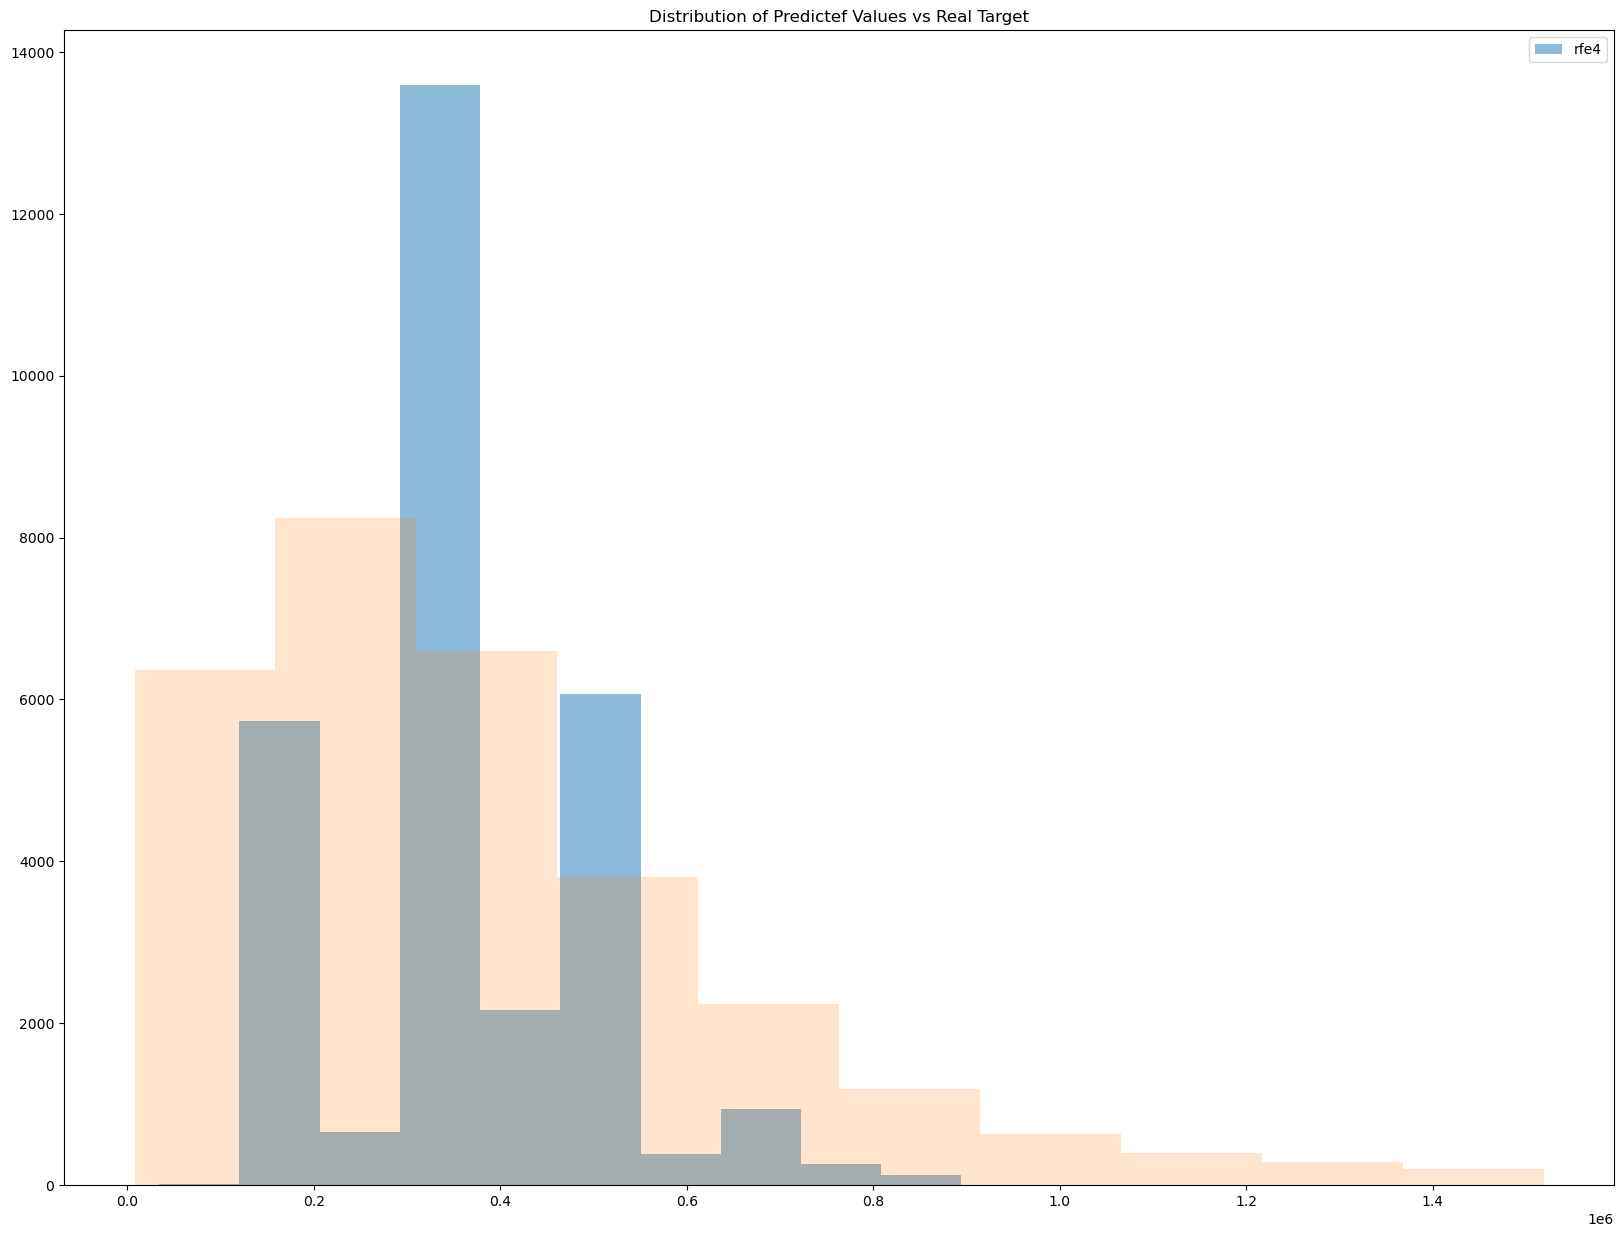

In [73]:
plt.figure(figsize=(20,15))
plt.hist(lr3.predict(X_train_rfe_3), alpha = 0.5, label = 'rfe4')
plt.hist(y_train, alpha = 0.2)
plt.legend()
plt.title('Distribution of Predictef Values vs Real Target')
plt.show()

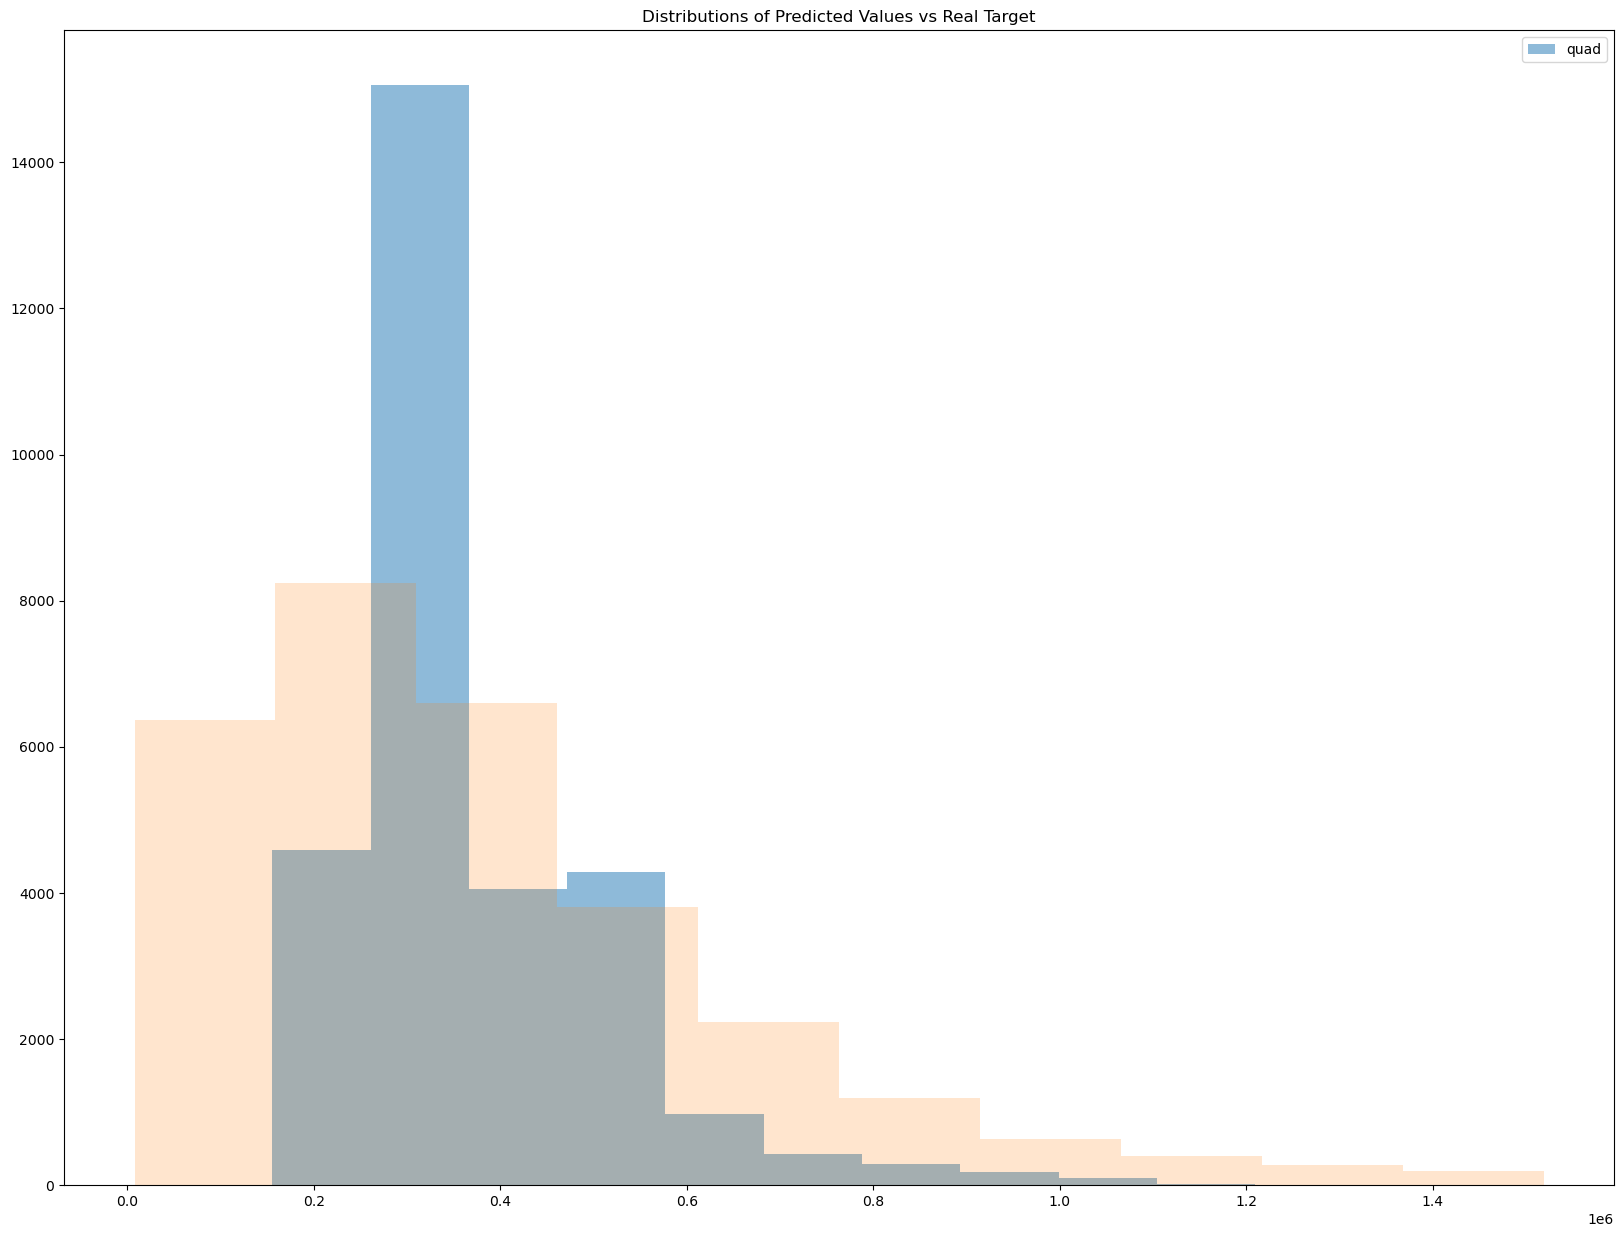

In [74]:
plt.figure(figsize=(20,15))
plt.hist(plyreg.predict(x_train_sq), alpha=0.5, label='quad')
plt.hist(y_train, alpha=0.2)
plt.legend()
plt.title('Distributions of Predicted Values vs Real Target')
plt.show()

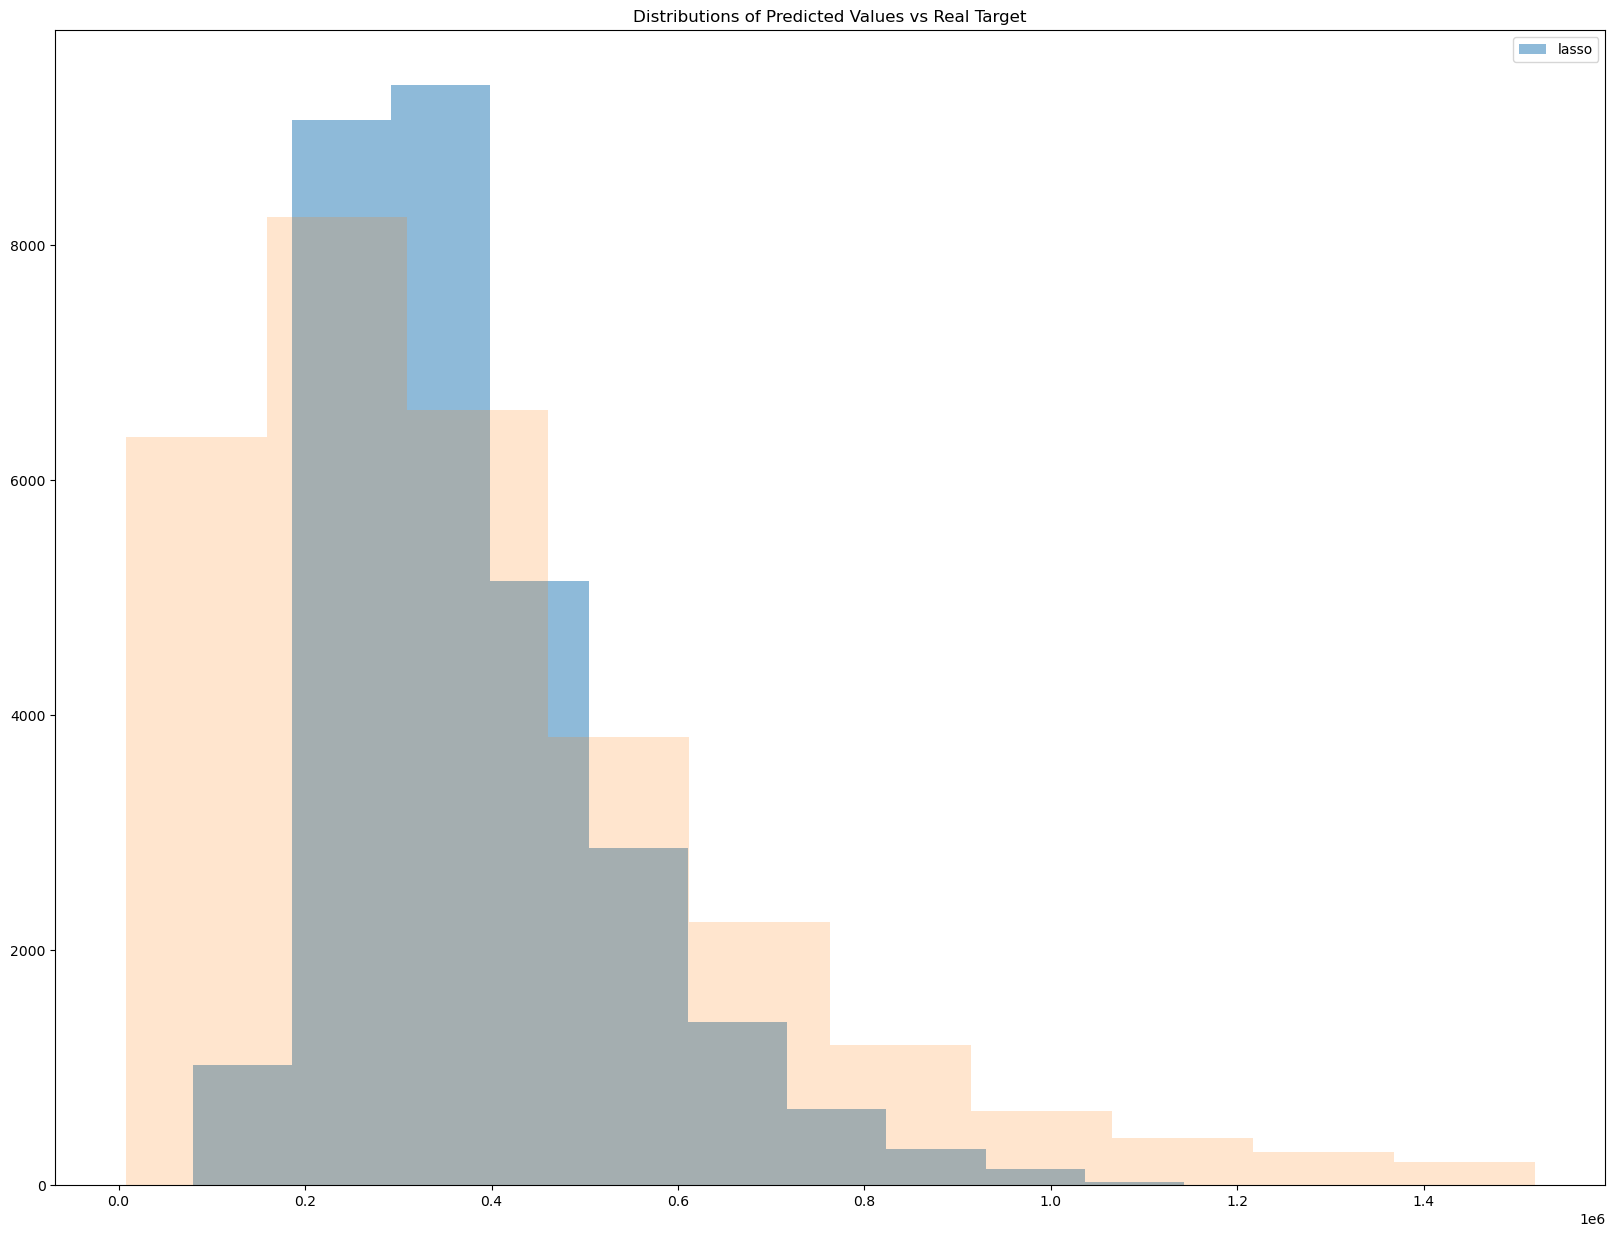

In [75]:
plt.figure(figsize=(20,15))
plt.hist(lasso.predict(X_train), alpha=0.5, label='lasso')
plt.hist(y_train, alpha=0.2)
plt.legend()
plt.title('Distributions of Predicted Values vs Real Target')
plt.show()

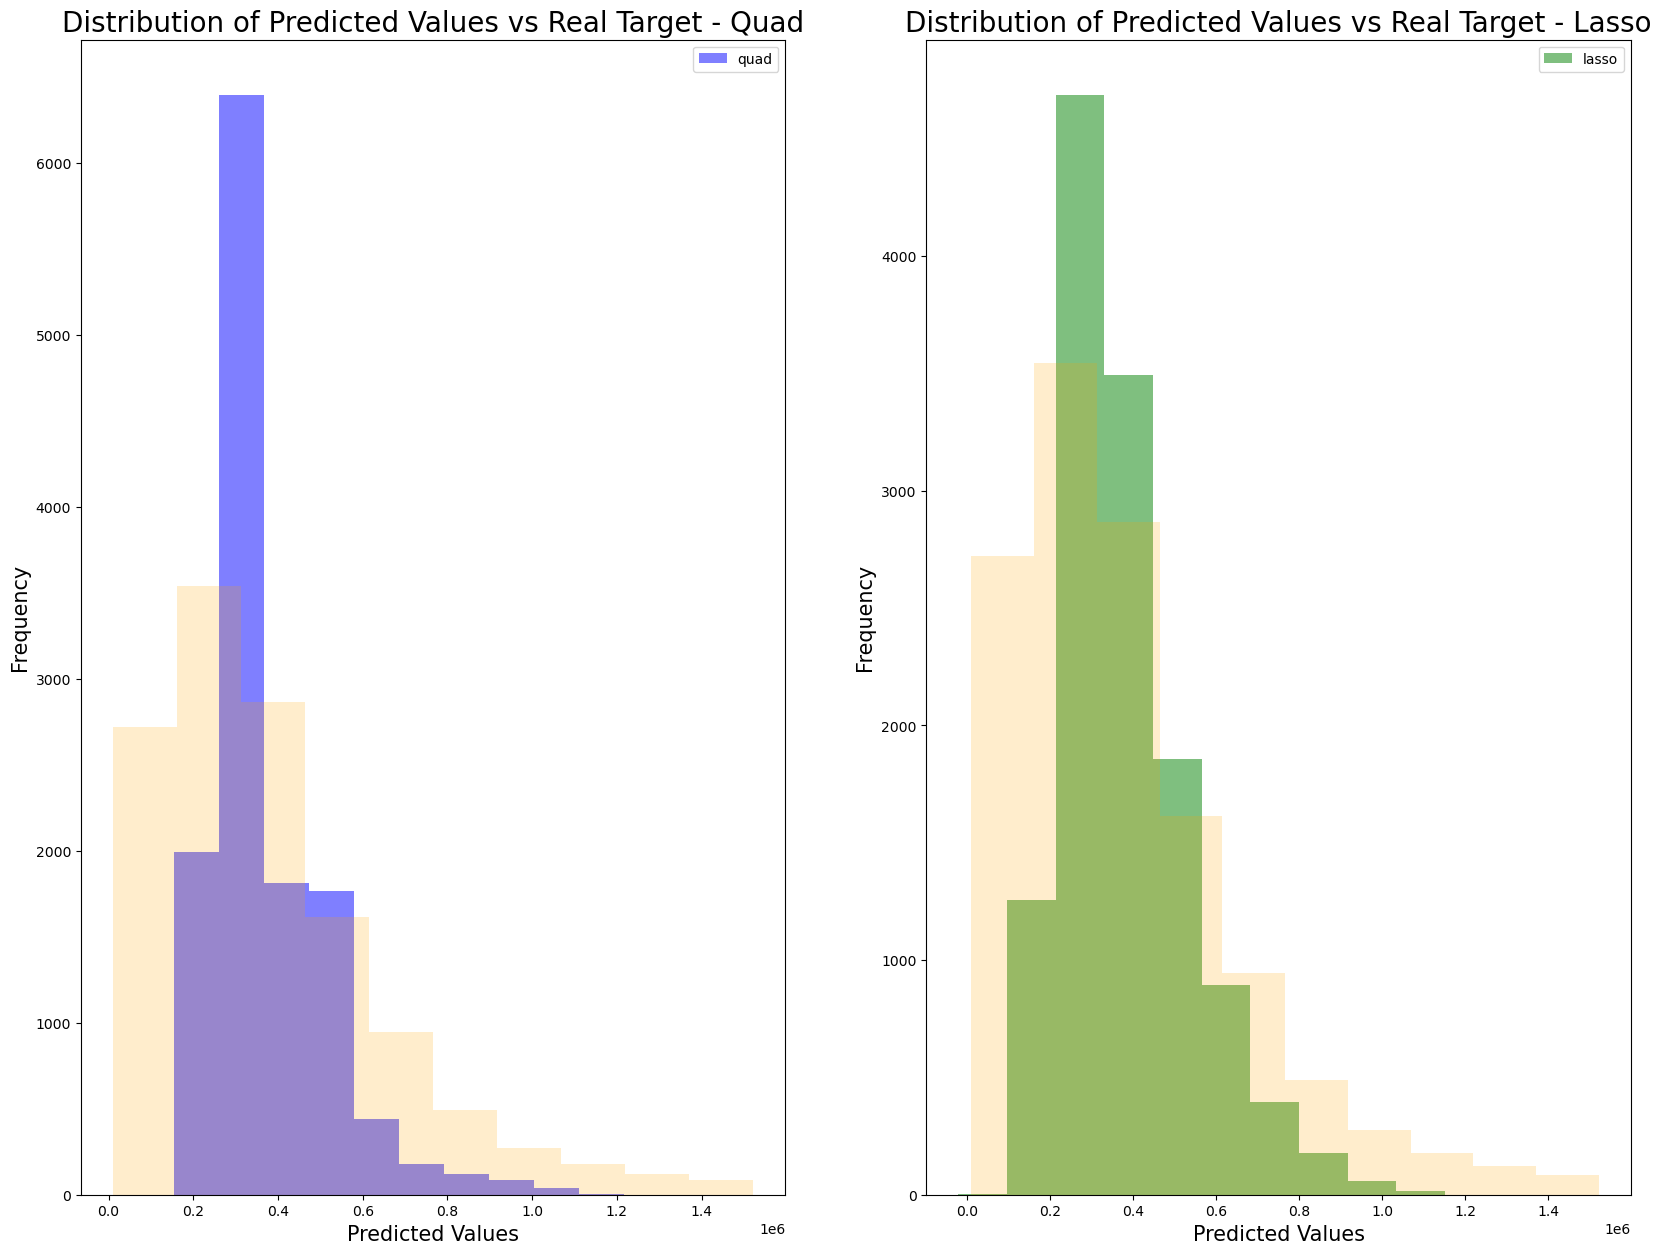

In [77]:
plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)
plt.hist(plyreg.predict(x_val_sq), alpha=0.5, label='quad', color='blue')
plt.hist(y_validate, alpha=0.2, color='orange')
plt.legend()
plt.title('Distribution of Predicted Values vs Real Target - Quad', fontsize=20)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# Plotting the second histogram (lasso)
plt.subplot(1, 2, 2)
plt.hist(lasso.predict(X_validate), alpha=0.5, label='lasso', color='green')
plt.hist(y_validate, alpha=0.2, color='orange')
plt.legend()
plt.title('Distribution of Predicted Values vs Real Target - Lasso', fontsize=20)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# Show the plots
plt.show()